# Resting State - Classical Features - KMeans Clustering

## 0. Imports & Constants

### Libraries

In [ ]:
import os
import sys
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.base import clone

import umap.umap_ as umap

In [ ]:
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from FeatureExtraction import FeatureExtractor, FEUtilz
from ClusteringUtilz import *

### Constans

In [3]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
FEATURES_DATA_PATH = rf"..\..\results\Resting State - best\resting_state_feature_table_22_05_2025_16_25.csv"
CLINICAL_DATA_PATH = rf'C:\Users\97254\Projects Data\ClusteringPD\cluestring_pd_clinical_data.xlsx'

CLINICAL_FEATURE_NAMES = ['Age', 'Disease duration', 
                        'LEDD', 'MoCA', 'UPDRS Total', 'UPDRS part III', 
                        'Gait speed usual', 'Gait speed DT', 
                        'CTT1', 'CTT2']

VGNG_FEATURE_NAMES = ['Vgng_sit_GO_CorrectPercent', 'Vgng_sit_NOGO_CorrectPercent', 'Vgng_walk_GO_CorrectPercent', 
                    'Vgng_walk_NOGO_CorrectPercent', 'Vgng_sit_GO_RT_Mean', 'Vgng_walk_GO_RT_Mean']

MODEL_FEATURE_NAMES = [
    'LZC_mean', 'PermEn_mean', 'fooof_exponent', 
    'beta_relative_bandpower', 'gamma_relative_bandpower', 'alpha_relative_bandpower', 'theta_relative_bandpower'
]

N_SEARCHES = 100
RANDOM_STATE = 42

### Import Data

In [5]:
feature_table = pd.read_csv(FEATURES_DATA_PATH)
feature_table = feature_table.loc[feature_table['FeatureName'].isin(MODEL_FEATURE_NAMES)]
feature_table['Task'] = feature_table['Condition'].str.split('_').str[0]
feature_table['Condition'] = feature_table['Condition'].str.split('_').str[1]

In [6]:
feature_table['FeatureName'].unique()

array(['LZC_mean', 'PermEn_mean', 'fooof_exponent',
       'theta_relative_bandpower', 'alpha_relative_bandpower',
       'beta_relative_bandpower', 'gamma_relative_bandpower'],
      dtype=object)

In [7]:
data, subjects, raw_feature_names = FEUtilz.get_feature_matrix(feature_table, normalize=True, agg_regions=True)

In [8]:
PD_mask = pd.Series(subjects).str.startswith('PD')

PD_data = data[PD_mask, :]
HC_data = data[~PD_mask, :]

PD_subjects = subjects[PD_mask]

In [9]:
PD_data.shape

(116, 182)

### A Vanilla Model

In [160]:
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [161]:
vanilla_kmeans = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('KMeans', KMeans(n_clusters=3))
])

In [ ]:
evaluator = ClusterReport(models=[vanilla_kmeans], model_names=['Vanilla Model'], cl_data_path=CLINICAL_DATA_PATH, cl_fnames=CLINICAL_FEATURE_NAMES
                       , PD_data=PD_data, PD_subjects=PD_subjects, HC_data=HC_data, cl_VGNG_names=VGNG_FEATURE_NAMES)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------

ModelName        Vanilla Model          
Statistic                 Mean       STD
Metric                                  
CH_score             30.375918  1.908484
DBI_score             1.779361  0.082090
Validity              1.000000  0.000000
silhouette_score      0.156570  0.008419 

-------------------------------------- Low Dimensional Visualization -------------------------------------



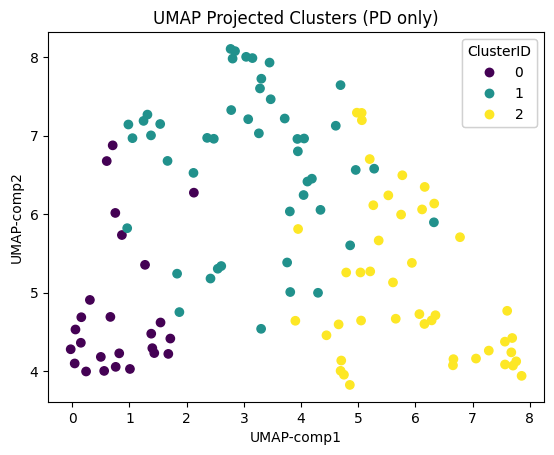

-------------------------------------- Clinical Metrics Differences -------------------------------------



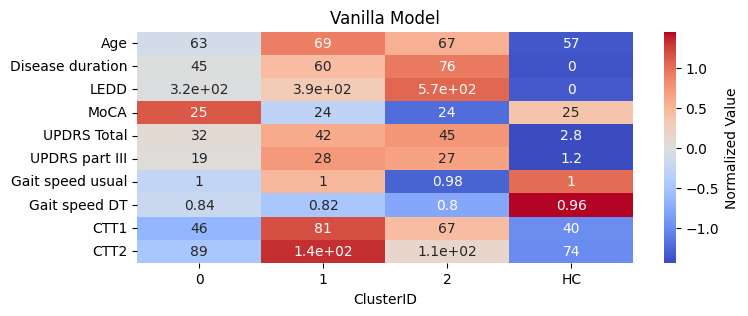

-------------------------------------- VGNG-related Metrics Differences -------------------------------------



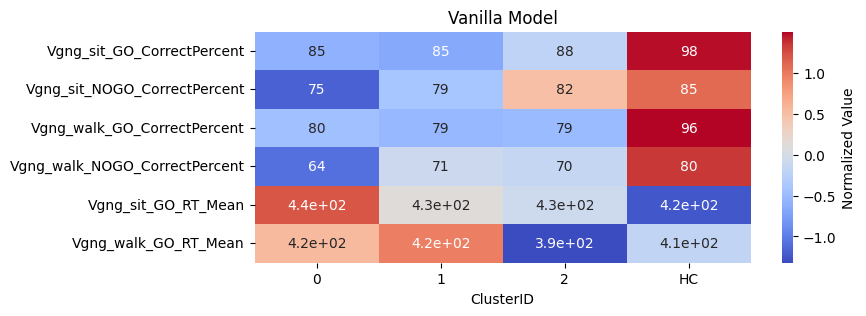

In [163]:
evaluator.report()

## 1. Hyperparameter Tuning

In [164]:
def silhouette_scorer(estimator, X, y=None):
    Xp = estimator[:-1].transform(X)
    labels = estimator.predict(X)
    return silhouette_score(Xp, labels)

In [165]:
cv = LeaveOneOutTrainEval()

### Vanilla-KMeans

#### K = 2

In [166]:
vanilla_kmeans_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('KMeans', KMeans(n_clusters=2))
])

vanilla_kmeans_2.fit(PD_data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', StandardScaler())])),
                ('KMeans', KMeans(n_clusters=2))])

#### K = 3

In [167]:
vanilla_kmeans_3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('KMeans', KMeans(n_clusters=3))
])

vanilla_kmeans_3.fit(PD_data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', StandardScaler())])),
                ('KMeans', KMeans(n_clusters=3))])

### PCA-KMeans

#### K = 2

In [168]:
PCA_kmeans_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('PCA', PCA()),
    ('KMeans', KMeans(n_clusters=2))
])

PCA_params = {
    'PCA__n_components': [0.7, 0.8, 0.9, 0.95]
}

PCA_kmeans_grid_2 = RandomizedSearchCV(
    PCA_kmeans_2,
    PCA_params,
    scoring=silhouette_scorer,
    cv=cv,
    n_iter=N_SEARCHES,
    verbose=1
)

In [169]:
PCA_kmeans_grid_2.fit(PD_data)

Fitting 116 folds for each of 4 candidates, totalling 464 fits


KeyboardInterrupt: 

In [ ]:
PCA_kmeans_grid_2.best_estimator_.named_steps['PCA'].n_components_

np.int64(5)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------

ModelName               PCA              Vanilla          
Statistic              Mean       STD       Mean       STD
Metric                                                    
CH_score          60.848675  0.706122  38.425793  4.689264
DBI_score          1.250704  0.010392   1.592833  0.141611
Validity           1.000000  0.000000   1.000000  0.000000
silhouette_score   0.298779  0.002880   0.214909  0.015746 

-------------------------------------- Low Dimensional Visualization -------------------------------------



<Figure size 640x480 with 0 Axes>

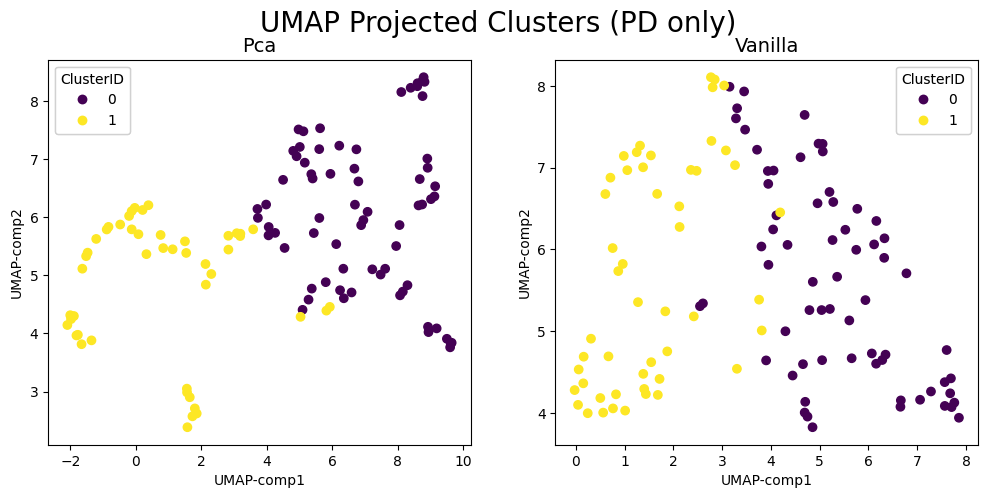

In [ ]:
evaluator.set_models(models=[PCA_kmeans_grid_2.best_estimator_, vanilla_kmeans_2], model_names=['PCA', 'Vanilla'])
evaluator.report(include_clinical=False)

#### K = 3

In [ ]:
PCA_kmeans_3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('PCA', PCA()),
    ('KMeans', KMeans(n_clusters=3))
])

PCA_kmeans_grid_3 = RandomizedSearchCV(
    PCA_kmeans_3,
    PCA_params,
    scoring=silhouette_scorer,
    cv=cv,
    n_iter=N_SEARCHES,
    verbose=1
)

In [ ]:
PCA_kmeans_grid_3.fit(PD_data)

Fitting 116 folds for each of 4 candidates, totalling 464 fits


RandomizedSearchCV(cv=LeaveOneOutTrainEval(),
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer()),
                                                              ('scaler',
                                                               StandardScaler())])),
                                             ('PCA', PCA()),
                                             ('KMeans', KMeans(n_clusters=3))]),
                   n_iter=100,
                   param_distributions={'PCA__n_components': [0.7, 0.8, 0.9,
                                                              0.95]},
                   scoring=<function silhouette_scorer at 0x000001DEE502D080>,
                   verbose=1)

In [ ]:
PCA_kmeans_grid_3.best_estimator_.named_steps['PCA'].n_components_

np.int64(5)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------

ModelName               PCA              Vanilla          
Statistic              Mean       STD       Mean       STD
Metric                                                    
CH_score          51.111248  4.710892  30.240950  2.230917
DBI_score          1.302396  0.086628   1.771289  0.113611
Validity           1.000000  0.000000   1.000000  0.000000
silhouette_score   0.242225  0.014363   0.157941  0.010231 

-------------------------------------- Low Dimensional Visualization -------------------------------------



<Figure size 640x480 with 0 Axes>

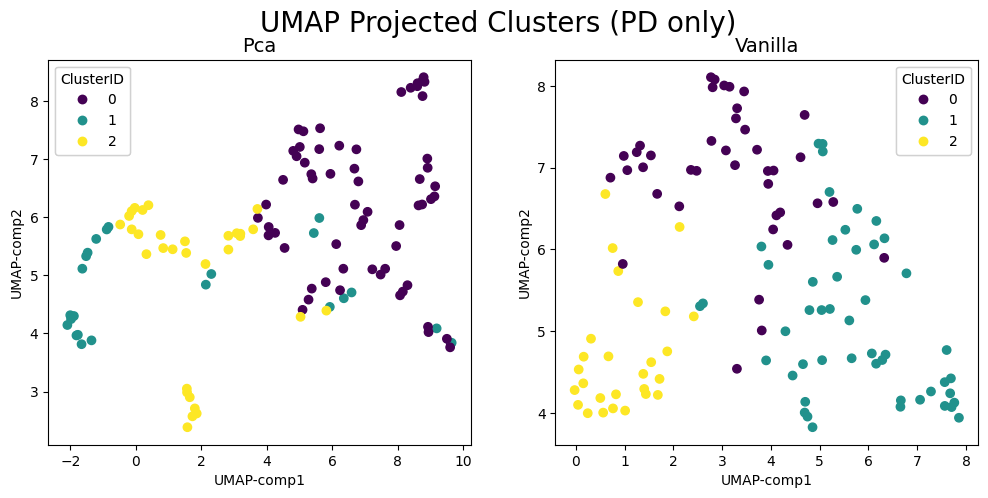

In [ ]:
evaluator.set_models(models=[PCA_kmeans_grid_3.best_estimator_, vanilla_kmeans_3], model_names=['PCA', 'Vanilla'])
evaluator.report(include_clinical=False)

### UMAP-KMeans

#### K = 2

In [ ]:
UMAP_kmeans_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('UMAP', umap.UMAP()),
    ('KMeans', KMeans(n_clusters=2))
])

UMAP_params = {
    'UMAP__n_components': np.arange(3, 22, 3),
    'UMAP__n_neighbors': np.arange(5, 21, 5)
}

UMAP_kmeans_grid_2 = RandomizedSearchCV(
    UMAP_kmeans_2,
    UMAP_params,
    scoring=silhouette_scorer,
    cv=cv,
    n_iter=N_SEARCHES,
    verbose=1
)

In [ ]:
UMAP_kmeans_grid_2.fit(PD_data)

Fitting 116 folds for each of 28 candidates, totalling 3248 fits


RandomizedSearchCV(cv=LeaveOneOutTrainEval(),
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer()),
                                                              ('scaler',
                                                               StandardScaler())])),
                                             ('UMAP', UMAP()),
                                             ('KMeans', KMeans(n_clusters=2))]),
                   n_iter=100,
                   param_distributions={'UMAP__n_components': array([ 3,  6,  9, 12, 15, 18, 21]),
                                        'UMAP__n_neighbors': array([ 5, 10, 15, 20])},
                   scoring=<function silhouette_scorer at 0x000001DEE502D080>,
                   verbose=1)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------

ModelName               UMAP               Vanilla          
Statistic               Mean        STD       Mean       STD
Metric                                                      
CH_score          129.417540  25.706594  38.447045  4.691320
DBI_score           0.831257   0.114606   1.590224  0.141404
Validity            1.000000   0.000000   1.000000  0.000000
silhouette_score    0.468023   0.044531   0.215187  0.015818 

-------------------------------------- Low Dimensional Visualization -------------------------------------



<Figure size 640x480 with 0 Axes>

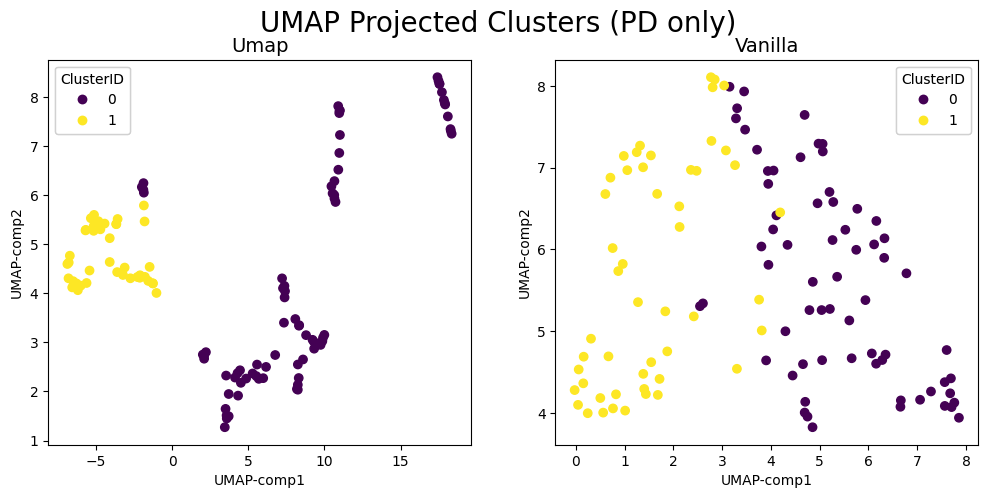

In [ ]:
evaluator.set_models(models=[UMAP_kmeans_grid_2.best_estimator_, vanilla_kmeans_2], model_names=['UMAP', 'Vanilla'])
evaluator.report(include_clinical=False)

#### K = 3

In [ ]:
UMAP_kmeans_3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('UMAP', umap.UMAP()),
    ('KMeans', KMeans(n_clusters=3))
])

UMAP_kmeans_grid_3 = RandomizedSearchCV(
    UMAP_kmeans_3,
    UMAP_params,
    scoring=silhouette_scorer,
    cv=cv,
    n_iter=N_SEARCHES,
    verbose=1
)

In [ ]:
UMAP_kmeans_grid_3.fit(PD_data)

Fitting 116 folds for each of 28 candidates, totalling 3248 fits


RandomizedSearchCV(cv=LeaveOneOutTrainEval(),
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer()),
                                                              ('scaler',
                                                               StandardScaler())])),
                                             ('UMAP', UMAP()),
                                             ('KMeans', KMeans(n_clusters=3))]),
                   n_iter=100,
                   param_distributions={'UMAP__n_components': array([ 3,  6,  9, 12, 15, 18, 21]),
                                        'UMAP__n_neighbors': array([ 5, 10, 15, 20])},
                   scoring=<function silhouette_scorer at 0x000001DEE502D080>,
                   verbose=1)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------

ModelName               UMAP               Vanilla          
Statistic               Mean        STD       Mean       STD
Metric                                                      
CH_score          157.605778  20.154979  30.174651  2.022510
DBI_score           0.764398   0.035410   1.767893  0.100747
Validity            1.000000   0.000000   1.000000  0.000000
silhouette_score    0.456050   0.019084   0.156954  0.010054 

-------------------------------------- Low Dimensional Visualization -------------------------------------



<Figure size 640x480 with 0 Axes>

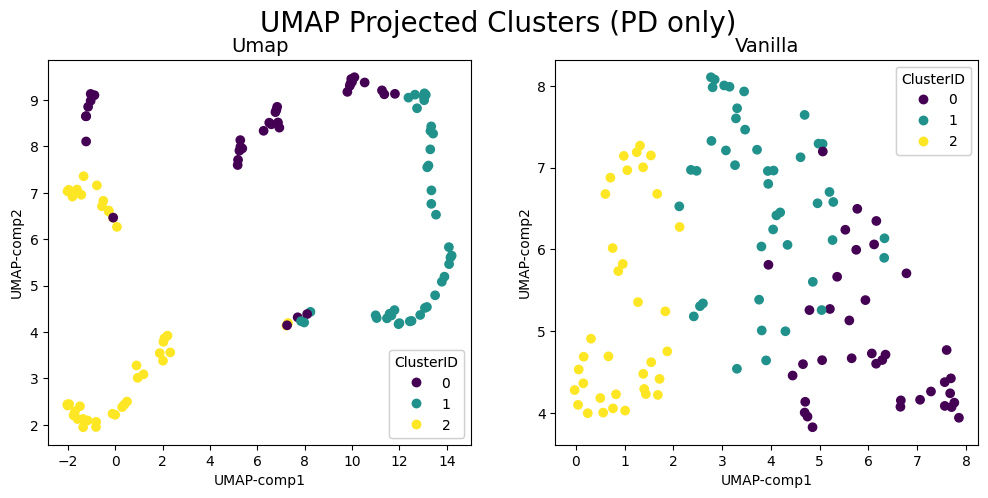

In [ ]:
evaluator.set_models(models=[UMAP_kmeans_grid_3.best_estimator_, vanilla_kmeans_3], model_names=['UMAP', 'Vanilla'])
evaluator.report(include_clinical=False)

### Stability

In [ ]:
def calc_stability(estimator, data: np.ndarray, name: str, validation_trials: int = 100):
    clusters = [estimator.fit_predict(data) for _ in range(validation_trials)]

    ARIs = [
        adjusted_rand_score(clusters[i], clusters[j])
        for i in range(validation_trials)
        for j in range(i+1, validation_trials)
    ]

    mean_ARI = np.mean(ARIs)
    std_ARI = np.std(ARIs)
    print(f"Adjusted Rand Index for {name} is {round(mean_ARI, 2)} ({round(std_ARI, 2)}) [mean (std)].")

In [ ]:
calc_stability(vanilla_kmeans_2, PD_data, name='Vanilla-KMeans [K=2]')

Adjusted Rand Index for Vanilla-KMeans [K=2] is 0.95 (0.05) [mean (std)].


In [ ]:
calc_stability(vanilla_kmeans_3, PD_data, name='Vanilla-KMeans [K=3]')

Adjusted Rand Index for Vanilla-KMeans [K=3] is 0.7 (0.27) [mean (std)].


In [ ]:
calc_stability(PCA_kmeans_2, PD_data, name='PCA-KMeans [K=2]')

Adjusted Rand Index for PCA-KMeans [K=2] is 0.89 (0.23) [mean (std)].


In [ ]:
calc_stability(PCA_kmeans_3, PD_data, name='PCA-KMeans [K=3]')

Adjusted Rand Index for PCA-KMeans [K=3] is 0.71 (0.28) [mean (std)].


In [ ]:
calc_stability(UMAP_kmeans_2, PD_data, name='UMAP-KMeans [K=2]')

Adjusted Rand Index for UMAP-KMeans [K=2] is 0.79 (0.19) [mean (std)].


In [ ]:
calc_stability(UMAP_kmeans_3, PD_data, name='UMAP-KMeans [K=3]')

Adjusted Rand Index for UMAP-KMeans [K=3] is 0.84 (0.09) [mean (std)].


## 2. Best Model Training & Evaluation

### General Evaluation

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------

ModelName        UMAP-KMeans [K=3]           
Statistic                     Mean        STD
Metric                                       
CH_score                153.800141  22.336031
DBI_score                 0.777817   0.091318
Validity                  1.000000   0.000000
silhouette_score          0.454336   0.034714 

-------------------------------------- Low Dimensional Visualization -------------------------------------



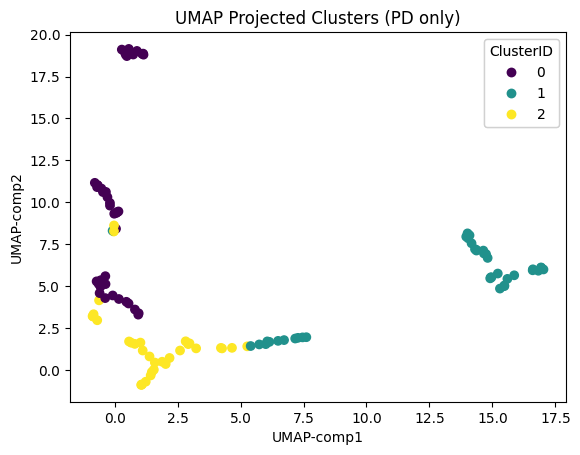

-------------------------------------- Clinical Metrics Differences -------------------------------------



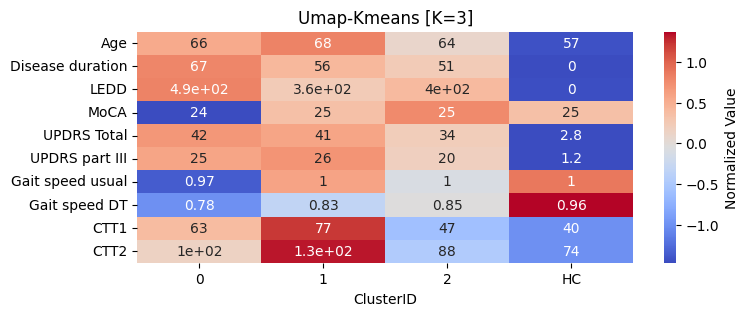

-------------------------------------- VGNG-related Metrics Differences -------------------------------------



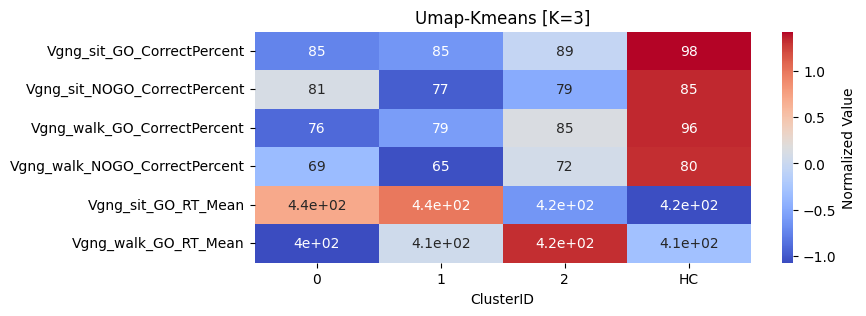

In [ ]:
best_model = UMAP_kmeans_grid_3.best_estimator_
best_model.named_steps['UMAP'].random_state = RANDOM_STATE
best_model.named_steps['KMeans'].random_state = RANDOM_STATE

joblib.dump(best_model, rf'Models\UMAP_KMeans.pkl')

evaluator.set_models(models=[best_model], names=['UMAP-KMeans [K=3]'])
evaluator.report()